In [3]:
import os
import sys
import inspect

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 


import h5py
import cv2
import numpy as np
from models.gazeheadResnet import GazeHeadResNet
import losses

import torch.optim as optim
from torch.optim import lr_scheduler

import torch
import torch.nn as nn
import time
from torch.utils.data import DataLoader

from numpy.random import default_rng

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def preprocess_image(image):
     ycrcb = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
     ycrcb[:, :, 0] = cv2.equalizeHist(ycrcb[:, :, 0])
     image = cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2RGB)
     image = np.transpose(image, [2, 0, 1])  # Colour image
     image = 2.0 * image / 255.0 - 1
     return image

def recover_image(x):
     x = (x + 1.0)*255.0/2.0
     x = np.clip(x, 0, 255) # Avoiding parts which have over or under flowed
     x = x.astype(np.uint0)
     
     x = np.transpose(x, [1, 2, 0]) # Channel, height and width to height width and channel

     x = x[:, :, ::-1] # Convertin  RGB to BGR since openCV uses that

     return x


def execute_step(model, X_numpy, labels_numpy, phase="train"):

    X_label = []
    for i in range(len(X_numpy)):
        X_label.append([X_numpy[i, :].astype(float), labels_numpy[i, :].astype(float)])

    dataloader = DataLoader(X_label, batch_size=128, shuffle=True)
    
    loss_list = []

    for  input, label in dataloader:

        if phase == "train":
            model.train()
        elif phase == "eval":
            model.eval()

        with torch.set_grad_enabled(phase == "train"):

            optimizer_ad.zero_grad()

            gaze_hat, head_hat = model(input.float().to(device))
            loss1 = criterion1(gaze_hat, label.to(device))
            

            #print("The estimated gaes are: " + str(gaze_hat))

            #print("The predicted labels are: " + str(label))
                    
            loss_list.extend(loss1.tolist())

            if phase == "train":
                loss2 = criterion( loss1, torch.zeros_like(loss1).to(device))
                loss2.backward()

                optimizer_ad.step()

                exp_lr_scheduler.step()

            #print("THe loss list is: " + str(loss_list))
    
    return loss_list
                    






In [5]:
def init_model(from_path=None):


     torch.cuda.empty_cache()

     #Model to be trained
     gaze_head_resnet = GazeHeadResNet()
     gaze_head_resnet = nn.DataParallel(gaze_head_resnet)
     gaze_head_resnet.to("cuda")

     #Criterion to minimize
     global criterion, criterion1
     criterion1 = losses.gaze_angular_loss
     criterion = nn.L1Loss()

     #Optimizer
     global optimizer_ad
     optimizer_ft = optim.SGD(gaze_head_resnet.parameters(), lr=0.8)

     optimizer_ad = optim.Adam(gaze_head_resnet.parameters(), 0.0003, (0.9, 0.95))

     global exp_lr_scheduler
     exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ad, step_size=50000, gamma=0.1)


     state_dict = {}
     if not from_path is None:
          checkpoint = torch.load(from_path)
          for key in checkpoint.keys():
               state_dict["module." + key] = checkpoint[key]

          gaze_head_resnet.load_state_dict(checkpoint)

     print("Done Initializing the model")

     return gaze_head_resnet

In [6]:
def iterate_and_train_model(h5_path, model, num_epochs=4, num_img=10, data="aug"):


    person_samples_dict = {}
    mean_losses = []
    total_imgs = 0
    
    for epoch in range(num_epochs):
        #Cell for Iterating over the HDF5 file and training the data

        loss_list = []
        gaze_list = []

        group_key = "image" if data == "aug" else "pixels"
        # print("The data is : " + str(data))
        # print("The group key is " + str(group_key))

        with h5py.File(h5_path, 'r') as f:
            cnt = 0

    
    
            for person_id, group in f.items():
                #print(group["labels"][0, :2])

        
                gaze_curr_list = []
                #gaze_list.extend(group["gaze"][:].tolist())

                #Choose 10 random images from for the group
                if not person_id in person_samples_dict:
                    rng = default_rng()
                    len_pix = len(group[group_key])
                    size = min(num_img, len_pix)
                    person_samples_dict[person_id] = rng.choice(len(group[group_key]), size=size, replace=False)

                numbers = person_samples_dict[person_id]
                X_numpy = np.zeros((len(numbers), 3, 128, 128), dtype=np.float)


                cnt1 = 0

                for idx in numbers:

                    if data == "gc":
                        eyes = preprocess_image(group["pixels"][idx, :])
                        gaze = group['labels'][idx, :2]
                    else:
                        eyes = group["image"][idx][:]
                        gaze = group["gaze"][idx, :2]

                    # if cnt < 10:
                        # cv2.imwrite("/bigpool/fachpraktikum2021/group5/dir_srinivas/outputs_sted/recovered_" + str(cnt) + ".png", recover_image(eyes))

                    X_numpy[cnt1] = eyes.astype(np.double)
                    cnt1 += 1

                    gaze_list.append(gaze)
                    gaze_curr_list.append(gaze)

                    cnt += 1
                    # if (cnt >= num_img):
                        # break


                
                train_size = int(1*(len(group[group_key])))
                dev_size = len(group[group_key]) - train_size

                
                if cnt >= num_img*1000:
                    train_size = num_img*1000 - (cnt - len(group[group_key]))

                X_train_numpy = X_numpy[:train_size,:]
                X_eval_numpy = X_numpy[train_size:, :]

                Y_train = gaze_curr_list[0:train_size]
                Y_eval = gaze_curr_list[train_size:]

                    
                #print("The length of train is: " + str(len(X_train_numpy)) )
                #print("The length of eval is: " + str(len(X_eval_numpy)) )

                loss_list.extend(execute_step(model, X_train_numpy, np.array(Y_train), "train"))
                #loss_list.extend(execute_training_step(X_eval_numpy, np.array(Y_eval), "eval"))


                if(cnt >= num_img*1000):
                    break


                '''print("Finished processing : " + str(cnt) )
                print("The length of the list is: " + str(len(loss_list)))
                print("The mean loss is : " + str(np.mean(loss_list)))'''


        mean_losses.append(np.mean(loss_list))

        total_imgs = len(loss_list)
        print("The mean loss for " + str(total_imgs) + "k images,  after epoch: " + str(epoch + 1) + "is : " + str(np.mean(loss_list)))

        

        #loss_list = perform_prediction(X_numpy, np.array(gaze_list))
        print("Finished Computing the gaze")
    
    
    model_name = "gaze_head_resnet_" + data + "_randimg_" + str(num_img)  +  "_epo_" +str(num_epochs) + "_.pt"
    torch.save(model.state_dict(), 
"/bigpool/fachpraktikum2021/group5/dir_srinivas/STED-gaze/pre-trained/" + model_name)
    return model, mean_losses, total_imgs



In [7]:
def test_model(h5_path, model, data="aug"):

    loss_list = []
    gaze_list = []

    group_key = "image" if data == "aug" else "pixels"
    # print("The data is : " + str(data))
    # print("The group key is " + str(group_key))

    with h5py.File(h5_path, 'r') as f:
        cnt = 0

        for person_id, group in f.items():
            #print(group["labels"][0, :2])

        
            gaze_curr_list = []
            #gaze_list.extend(group["gaze"][:].tolist())

            X_numpy = np.zeros((len(group["pixels"]), 3, 128, 128), dtype=np.float)


            cnt1 = 0

            for idx in range(len(group["pixels"])):

                if data == "gc":
                    eyes = preprocess_image(group["pixels"][idx, :])
                    gaze = group['labels'][idx, :2]
                else:
                    eyes = group["image"][idx][:]
                    gaze = group["gaze"][idx, :2]

                # if cnt < 10:
                    # cv2.imwrite("/bigpool/fachpraktikum2021/group5/dir_srinivas/outputs_sted/recovered_" + str(cnt) + ".png", recover_image(eyes))

                X_numpy[cnt1] = eyes.astype(np.double)
                cnt1 += 1

                gaze_list.append(gaze)
                gaze_curr_list.append(gaze)

                cnt += 1
                # if (cnt >= num_img):
                    # break

            loss_list.extend(execute_step(model, X_numpy, np.array(gaze_curr_list), "test"))
            #loss_list.extend(execute_training_step(X_eval_numpy, np.array(Y_eval), "eval"))


            # if(cnt >= num_img):
                 # break


            '''print("Finished processing : " + str(cnt) )
            print("The length of the list is: " + str(len(loss_list)))
            print("The mean loss is : " + str(np.mean(loss_list)))'''


        

    #loss_list = perform_prediction(X_numpy, np.array(gaze_list))
    print("Finished Computing the gaze")
    
    
    return loss_list


In [13]:

#iterate_and_train_model(1, 1001)

trained_models = {
    "aug": [],
    "gc": [] 
}

h5_path_red = "/bigpool/fachpraktikum2021/group5/dir_srinivas/outputs_sted/Redirected_samples1.h5"
h5_path_gc = "/bigpool/fachpraktikum2021/group5/dir_srinivas/outputs_sted/GazeCapture.h5"


num_imgs = [1, 2, 5, 10, 20, 10]


for num_img in num_imgs:

    for ds in [ "gc", "aug"]:
    
        if ds == "gc":
            h5_path  = h5_path_gc
        else:
            h5_path = h5_path_red


        model = init_model()
        trained_model, mean_losses, total_imgs = iterate_and_train_model(h5_path, model, 20, num_img, ds)
        trained_models[ds].append({num_img : {"model":trained_model, "train_losses": mean_losses, "total_imgs":total_imgs}})


Done Initializing the model


<ipython-input-6-6cf3100a1c30>:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_numpy = np.zeros((len(numbers), 3, 128, 128), dtype=np.float)


The mean loss for 1000k images,  after epoch: 1is : 14.500081574844812
Finished Computing the gaze
The mean loss for 1000k images,  after epoch: 2is : 12.465527562918544
Finished Computing the gaze
The mean loss for 1000k images,  after epoch: 3is : 12.418579378807328
Finished Computing the gaze
The mean loss for 1000k images,  after epoch: 4is : 12.20887061558969
Finished Computing the gaze
The mean loss for 1000k images,  after epoch: 5is : 12.008155459116114
Finished Computing the gaze
The mean loss for 1000k images,  after epoch: 6is : 11.782931142662601
Finished Computing the gaze
The mean loss for 1000k images,  after epoch: 7is : 11.713594330358829
Finished Computing the gaze
The mean loss for 1000k images,  after epoch: 8is : 11.568904246178743
Finished Computing the gaze
The mean loss for 1000k images,  after epoch: 9is : 11.533698436693609
Finished Computing the gaze
The mean loss for 1000k images,  after epoch: 10is : 11.440738375833979
Finished Computing the gaze
The mean l

In [14]:


aug_test_losses = []
gc_test_losses = []
h5_path_mpii = "/bigpool/fachpraktikum2021/group5/dir_srinivas/outputs_sted/MPIIGaze.h5"


#print(trained_models["aug"][1].keys())
for ds in ["aug", "gc"]:
    for n_model in trained_models[ds]:
        
        key1 = list(n_model)[0]
        model = n_model[key1]["model"]
        if ds == "aug":
            aug_test_losses.append(np.mean(test_model(h5_path_mpii, model, "gc")))
        else:
            gc_test_losses.append(np.mean(test_model(h5_path_mpii, model, "gc")))

<ipython-input-7-46148b1bdd1c>:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_numpy = np.zeros((len(group["pixels"]), 3, 128, 128), dtype=np.float)


Finished Computing the gaze
Finished Computing the gaze
Finished Computing the gaze
Finished Computing the gaze
Finished Computing the gaze
Finished Computing the gaze
Finished Computing the gaze
Finished Computing the gaze


In [15]:
print(aug_test_losses)
print(gc_test_losses)

[13.59617201000423, 11.478111393958375, 6.5763315327586085, 5.579406692306492]
[14.450429288371582, 11.025838329695596, 7.1049912166347005, 6.217617283231051]


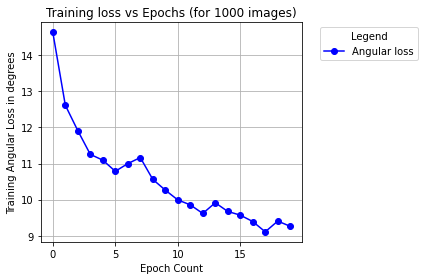

In [22]:

training_losses = trained_models["aug"][0][1]["train_losses"]
epochs = [epoch for epoch in range(len(training_losses))]

plt.close('all')
fig, ax = plt.subplots(tight_layout=True)

p1,  = ax.plot(epochs, training_losses,  color='blue', marker='o', label='Angular loss')

ax.set_title("Training loss vs Epochs (for 1000 images)")
ax.set_xlabel("Epoch Count")
ax.set_ylabel("Training Angular Loss in degrees")

ax.legend(handles=[p1], title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')

ax.grid(True)
fig.savefig('/bigpool/fachpraktikum2021/group5/dir_srinivas/STED-gaze/Gaze_Estimation/plots/' + 'training_loss.jpg',
            )
#plt.show()







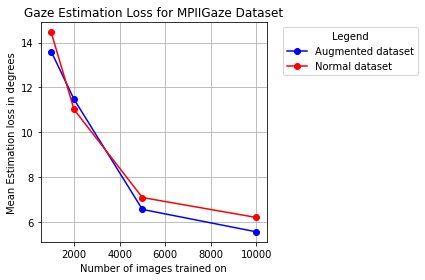

In [18]:

image_numbers = [1000, 2000, 5000, 10000]

plt.close('all')
fig, ax = plt.subplots(tight_layout=True)

p1,  = ax.plot(image_numbers, aug_test_losses, color='blue', marker='o', label='Augmented dataset')
p2,  = ax.plot(image_numbers, gc_test_losses, color='red', marker='o', label='Normal dataset')



ax.set_title("Gaze Estimation Loss for MPIIGaze Dataset")
ax.set_xlabel("Number of images trained on")
ax.set_ylabel("Mean Estimation loss in degrees")

ax.legend(handles=[p1, p2], title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')

ax.grid(True)
fig.savefig('/bigpool/fachpraktikum2021/group5/dir_srinivas/STED-gaze/Gaze_Estimation/plots/' + 'augvsnorm_comparison.jpg',
            )


In [ ]:
actual_numbers = [1364, 2727, 6815, 13620, 27196, ]

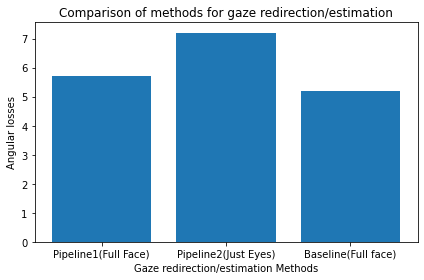

In [1]:
import matplotlib.pyplot as plt

# Create a Simple Bar Plot of Three People's Ages


plt.close('all')
fig, ax = plt.subplots(tight_layout=True)

ax.set_xlabel("Gaze redirection/estimation Methods")
ax.set_ylabel("Angular losses")
ax.set_title("Comparison of methods for gaze redirection/estimation")

# Create a List of Labels for x-axis
names = ["Pipeline1(Full Face)", "Pipeline2(Just Eyes)", "Baseline(Full face)"]

# Create a List of Values (Same Length as Names List)
errors = [5.7, 7.2, 5.2]

# Make the Chart
ax.bar(names, errors)
fig.savefig('/bigpool/fachpraktikum2021/group5/dir_srinivas/STED-gaze/Gaze_Estimation/plots/' + 'method_comparison.jpg',
            )


